# Notebook to generate plots of simulated datasets results

Be sure to have either downloaded or generated the motion estimation results
before running this notebook. See `../simulated_data/motion_estimation` for
details.

In [2]:
"""Imports."""

import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append('../simulated_data/motion_estimation')
import utils as motion_estimation_utils

In [11]:
"""Load dataframe."""

data_dict = {
    'dataset': [],
    'method': [],
    'error_l1': [],
    'drift_rate': [],
    'random_walk_sigma': [],
    'random_jump_rate': [],
    'unit_num': [],
    'homogeneity': [],
    'stability': [],
    'non_rigidity': [],
}
_METHODS = [
    'kilosort_datashift',
    'dredge',
    'rigid_fast',
    'medicine_rigid',
    'medicine',
]
_METHOD_NAMES = {
    'kilosort_datashift': 'Kilosort',
    'rigid_fast': 'DREDge\nUniform',
    'medicine_rigid': 'MEDiCINe\nUniform',
    'medicine': 'MEDiCINe',
    'dredge': 'DREDge',
}

for results_dir in motion_estimation_utils.MOTION_ESTIMATION_DIR.iterdir():
    if results_dir.name[0] == '.':
            continue
    if results_dir.name.endswith('.sh'):
        continue
    for error_dir in results_dir.iterdir():
        if error_dir.name[0] == '.':
            continue
        
        method = error_dir.name
        if method not in _METHODS:
            continue
        
        recording_dir = motion_estimation_utils.SIMULATED_DATASETS_DIR / results_dir.name
        hyperparams = json.load(
            open(recording_dir / 'hyperparameters.json', 'r'))
        
        mean_error_path = error_dir / 'mean_error_l1.npy'
        if not mean_error_path.exists():
            continue
        error_l1 = np.load(error_dir / 'mean_error_l1.npy')
        data_dict['dataset'].append(results_dir.name)
        data_dict['method'].append(method)
        data_dict['error_l1'].append(error_l1.item())
        for k, v in hyperparams.items():
            data_dict[k].append(v)
        
dataframe = pd.DataFrame(data_dict)

# Make sure each dataset has all methods
for dataset in dataframe.dataset.unique():
    dataset_df = dataframe[dataframe['dataset'] == dataset]
    for method in _METHODS:
        if method not in dataset_df['method'].values:
            raise ValueError(f'Missing method {method} for dataset {dataset}')

def _get_ranking(values):
    """Get ranking of values, handling ties."""
    ranking = []
    for value in values:
        ranking.append(np.sum(values <= value))
    return ranking
    
# Add method ranking to dataframe
for dataset in dataframe.dataset.unique():
    tmp_df = dataframe.loc[dataframe['dataset'] == dataset]
    num_merge_per_method = [
        tmp_df.loc[tmp_df['method'] == method, 'error_l1'].values[0]
        for method in _METHODS
    ]
    method_ranking = _get_ranking(num_merge_per_method)
    for method, rank in zip(_METHODS, method_ranking):
        dataframe.loc[
            (dataframe['dataset'] == dataset) & (dataframe['method'] == method),
            'method_ranking',
        ] = rank

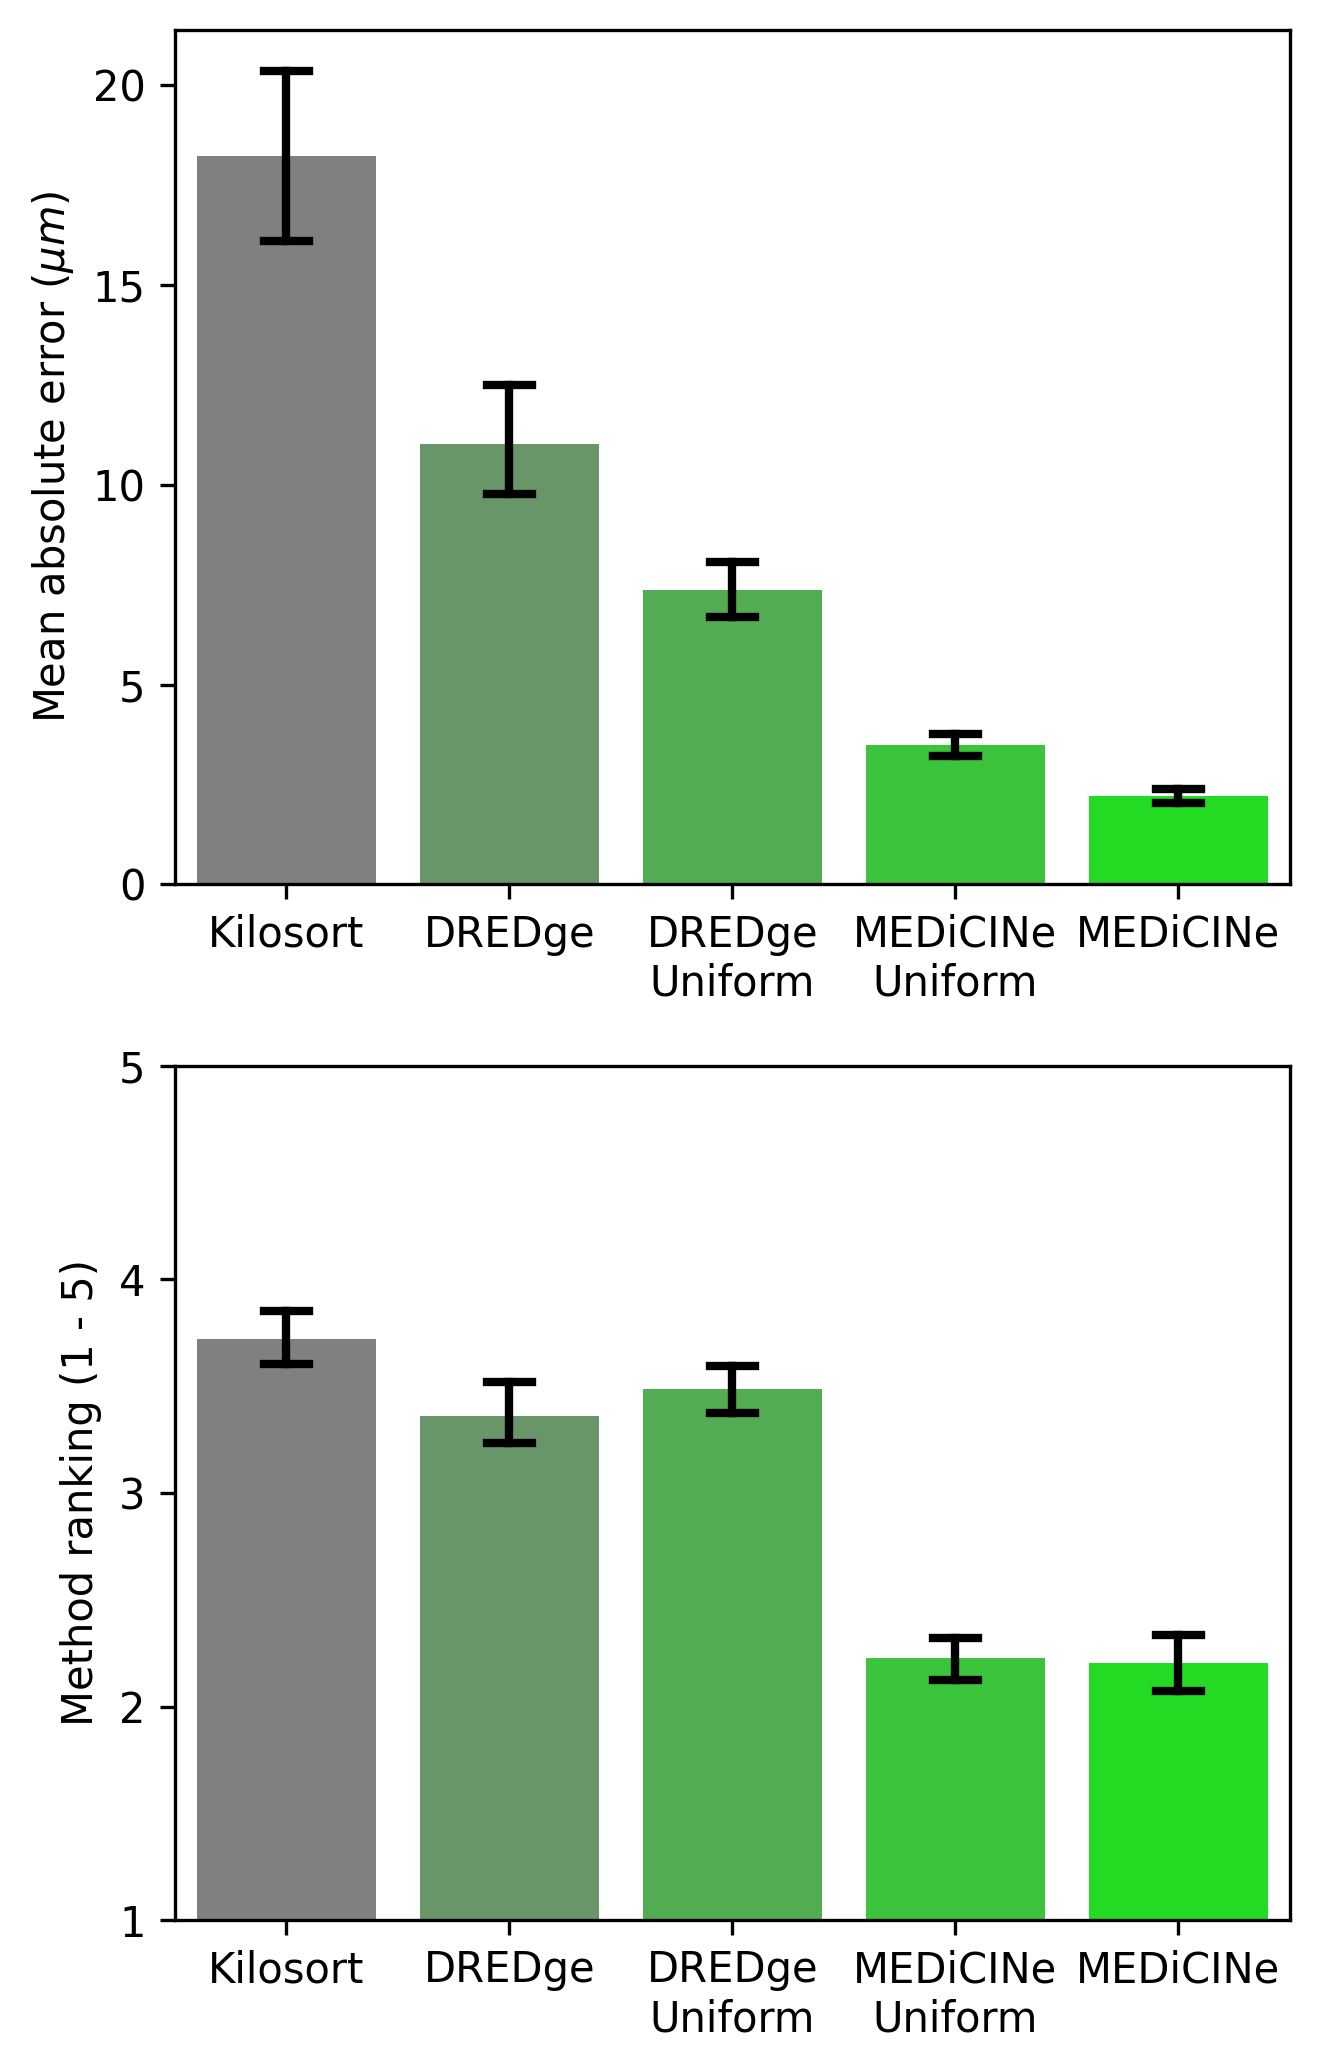

In [15]:
"""Plot errors."""

_PALETTE = {}
for i, method in enumerate(_METHODS):
    step = 0.12
    _PALETTE[method] = (0.5 - step * i, 0.5 + step * i, 0.5 - step * i)

# Plot overall error
fig, axes = plt.subplots(2, 1, figsize=(4.5, 7), dpi=300)
for ax, key in zip(axes, ['error_l1', 'method_ranking']):
    plot = sns.barplot(
        ax=ax,
        data=dataframe,
        y=key,
        x='method',
        order=_METHODS,
        hue='method',
        palette=_PALETTE,
        hue_order=_METHODS,
        legend=False,
        capsize=0.2,
        err_kws={'color': 'k', 'linewidth': 2},
    )
axes[0].set_ylabel('Mean absolute error ($\mu m$)')
axes[0].set_yticks(np.arange(0, 25, 5))
axes[1].set_ylabel('Method ranking (1 - 5)')
axes[1].set_ylim(1, len(_METHODS))
axes[1].set_yticks(np.arange(1, len(_METHODS) + 1))
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    ax.set_xticks([bar.get_x() + 0.5 * bar.get_width() for bar in ax.patches])
    ax.set_xticklabels([_METHOD_NAMES[method] for method in _METHODS], rotation=0)
    ax.set_xlabel('')
fig.tight_layout()